<a href="https://colab.research.google.com/github/yossefPartouche/Deep_Learning/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Basics: from a single conv layer to CNN



## Setup

In [1]:
!pip install -q torchinfo # https://pypi.org/project/torchinfo/
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ea3edd80ba5e88deb3d01125b0abeb8b25fb70716774ccfd0d9fd7dc7fcc14d2
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import time
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cpu


In [4]:
# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

## Data Loading and Preprocessing

In [5]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
# training dataset
full_train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]


In [7]:
# split size for validation data
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

# Split the full training set into a new training & validation set
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [8]:
BATCH_SIZE = 64

# Create DataLoaders for each set
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Exploratory Data Analysis (EDA)

Basic information

In [ ]:
print(f"Original Training Set Size: {len(full_train_dataset)}")
print(f"New Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")

Original Training Set Size: 60000
New Training Set Size: 48000
Validation Set Size: 12000
Test Set Size: 10000


In [10]:
# Get one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Images tensor shape: {images.shape}") # [batch_size, channels, height, width]
print(f"Labels tensor shape: {labels.shape}")

Images tensor shape: torch.Size([64, 1, 28, 28])
Labels tensor shape: torch.Size([64])


Visualize Sample Images

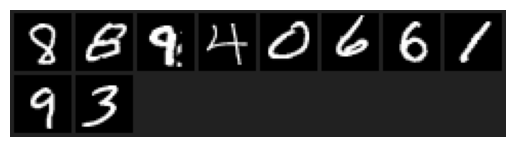

Labels: 8 8 9 4 0 6 6 1 9 3


In [13]:
def imshow(img):
    img = img * 0.3081 + 0.1307  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Show a grid of images
imshow(torchvision.utils.make_grid(images[:10]))

# Print the corresponding labels
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(10)))

Check Class Distribution

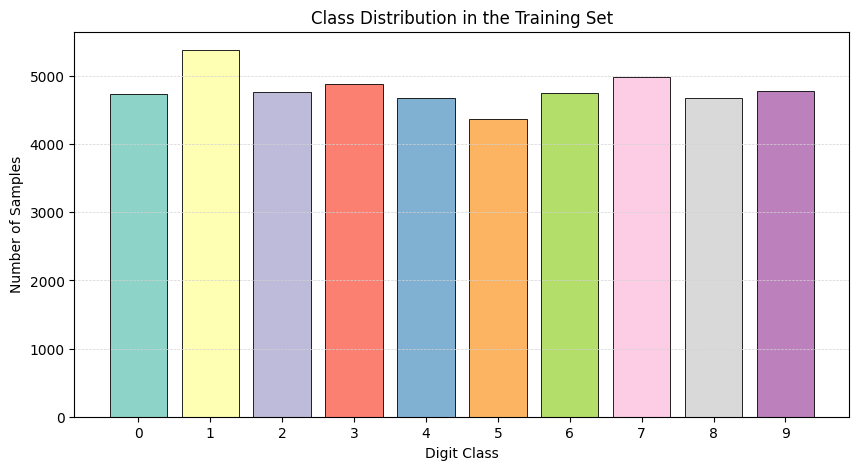

In [14]:
all_train_labels = [label for _, label in train_dataset]
class_counts = np.bincount(all_train_labels)
classes = [str(i) for i in range(10)]

colors = plt.cm.Set3(np.arange(len(classes)))

plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts, color=colors, edgecolor='black', linewidth=0.6)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Training Set')
plt.grid(color='lightgray', linestyle='--', linewidth=0.5, axis='y')
plt.show()

(1) **Why Are Balanced Datasets Important** ❓❓<br>
This is important so that the model isn't well trained on ony a subset of the labels, that we need to master.

(2) **Is this task simple** ❓❓ <br>
No, this task is complicated, we require to convert hand written integers and create spatial relations to specific Labels in a consistent and accurate manner.

#Convolutions and Filters

Convolution really just means “to pass over the data”.

What are we “passing”? Our filters - which are also called kernels.



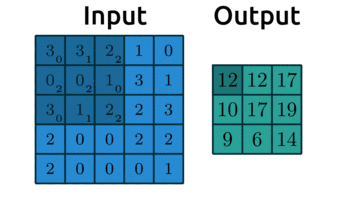



https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter5_cnns-pt1.html



## Convolution layers for feature extraction


So how does this help us extract structure from the data? Well let’s see some examples!



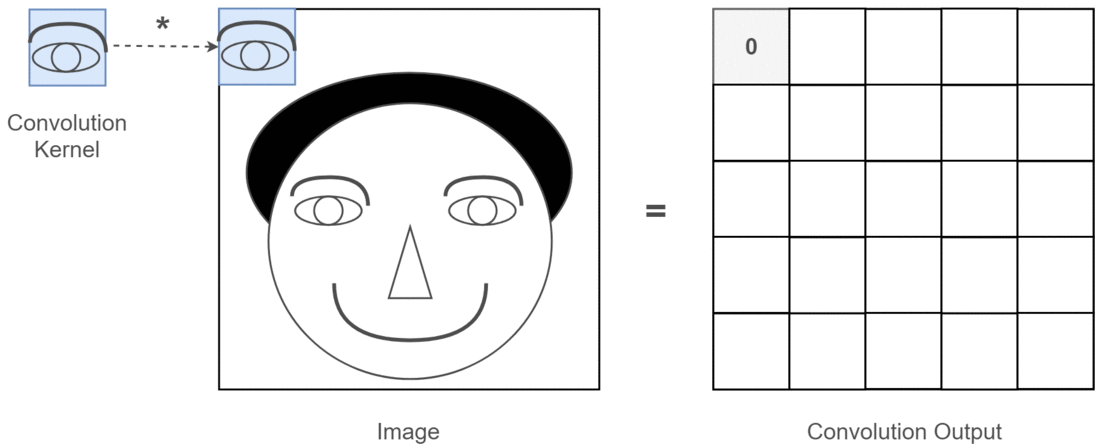


https://compneuro.neuromatch.io/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial2.html



Lower features are more general while higher features
are more specific.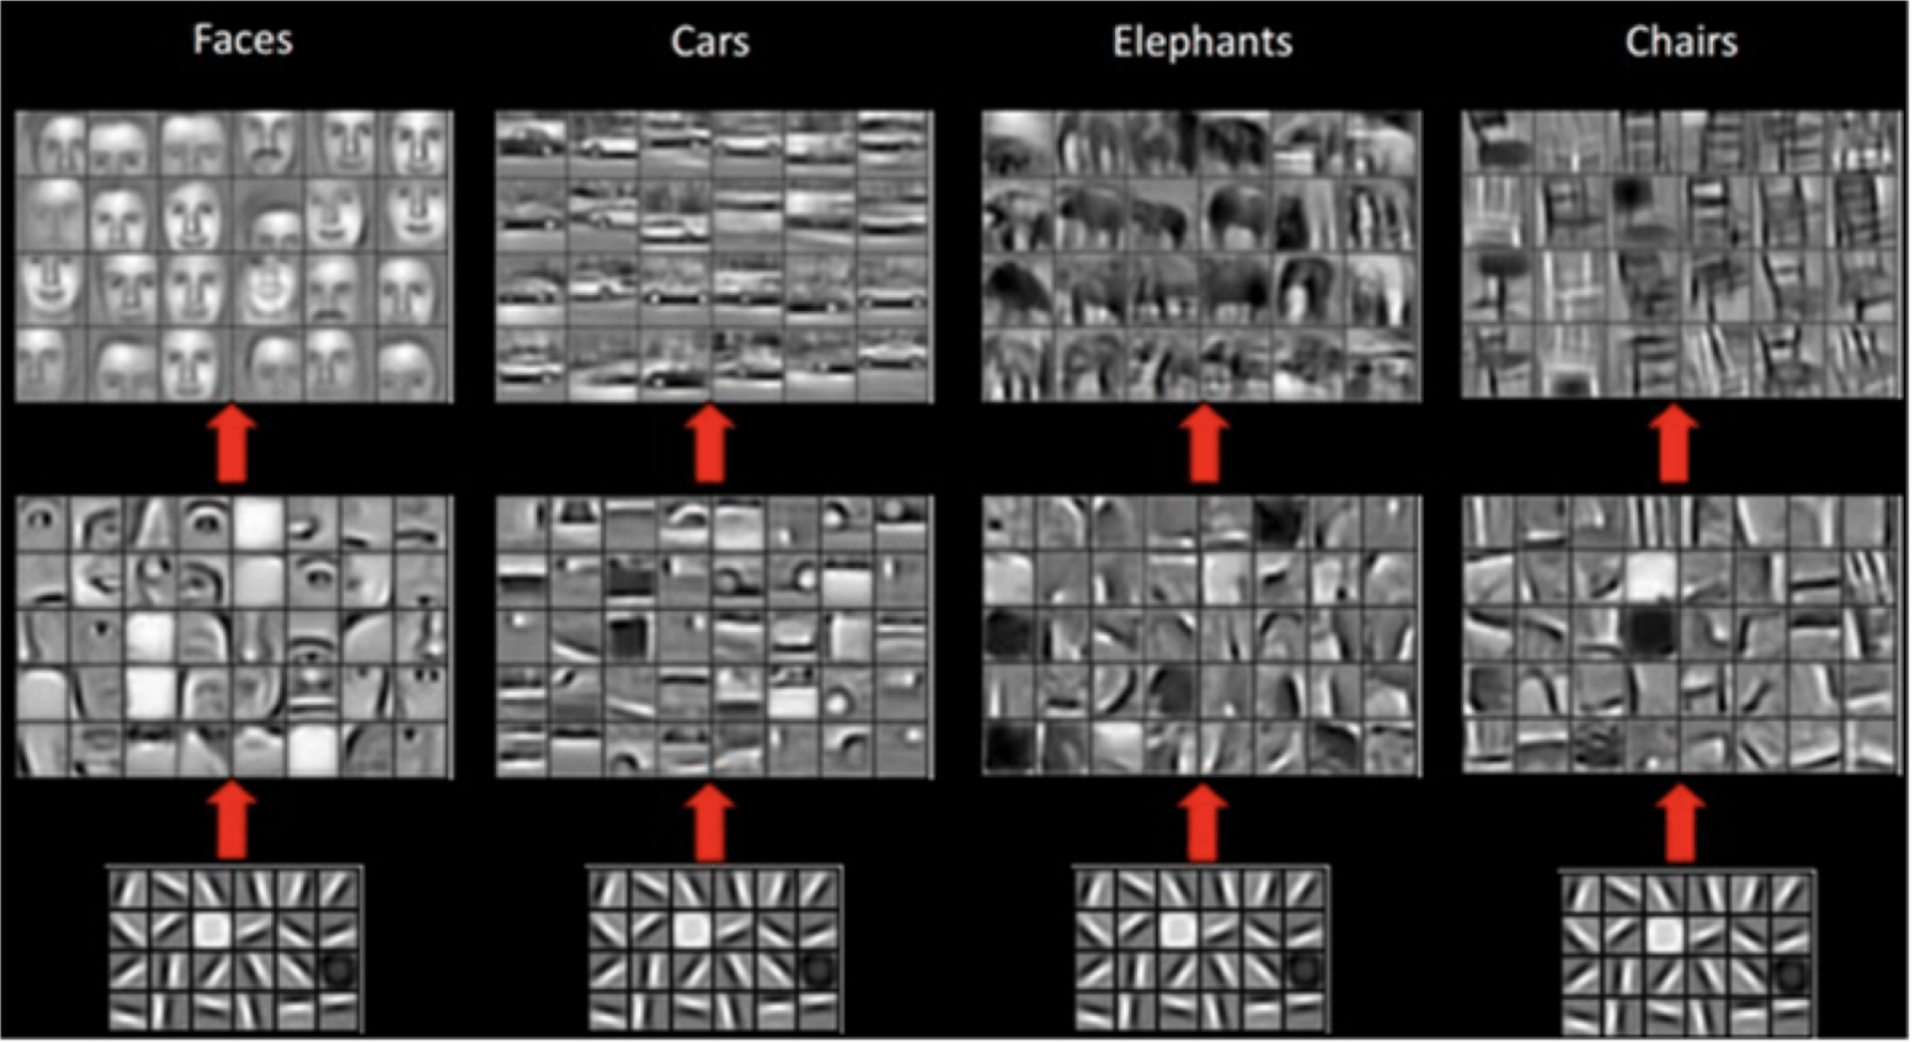

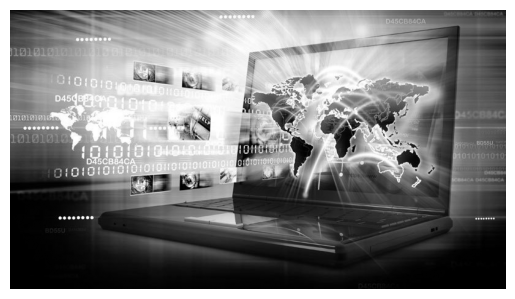

In [17]:
x = torch.from_numpy(plt.imread("/content/test_image.jpg")).float()  # [H,W,3] or [H,W,4]

# normalize if needed (some readers return 0..255)
if x.max() > 1:
    x = x / 255.0

# drop alpha channel if exists
if x.shape[-1] == 4:
    x = x[..., :3]

# RGB -> Gray using standard luminance weights
gray = 0.299 * x[..., 0] + 0.587 * x[..., 1] + 0.114 * x[..., 2]  # [H,W]

plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.show()

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
def to_gray2d(img):
    """img can be [H,W], [H,W,3], or [H,W,4]. Returns [H,W] float tensor in [0,1]."""
    x = img.float()
    if x.max() > 1:
        x = x / 255.0
    if x.ndim == 3 and x.shape[-1] == 4:
        x = x[..., :3]
    if x.ndim == 3 and x.shape[-1] == 3:
        x = 0.299*x[...,0] + 0.587*x[...,1] + 0.114*x[...,2]
    return x  # [H,W]

def plot_conv(gray, kernel, padding=None, show_diff=True):
    gray = to_gray2d(gray)               # ensure [H,W]
    k = kernel.float().to(gray.device)  # makes sure the kernel has the right data type and is on the same device as gray

    # Auto "same" padding for odd kernel sizes (3,5,7,...)
    if padding is None:
        kH, kW = k.shape[-2], k.shape[-1]
        padding = (kH // 2, kW // 2)

    # adds batch and channel dimensions
    x4 = gray.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    y = F.conv2d(x4, k, padding=padding)[0, 0]  # [H,W] (same size now)

    # Normalize for visualization
    y_vis = (y - y.min()) / (y.max() - y.min() + 1e-8)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Input (gray)")
    plt.imshow(gray.detach().cpu(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("After convolution (normalized)")
    plt.imshow(y_vis.detach().cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

    if show_diff:
        diff = (gray - y).abs()
        diff_vis = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)

        plt.figure(figsize=(5, 4))
        plt.title("Difference |gray - conv| (normalized)")
        plt.imshow(diff_vis.detach().cpu(), cmap="gray")
        plt.axis("off")
        plt.show()

    return y


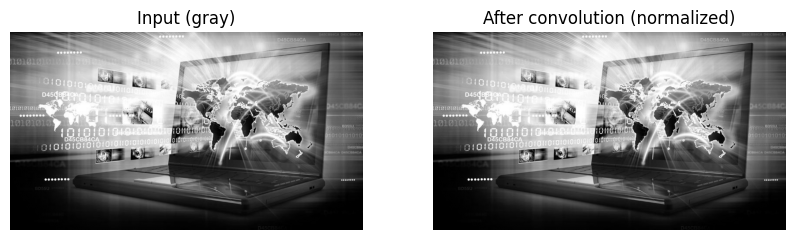

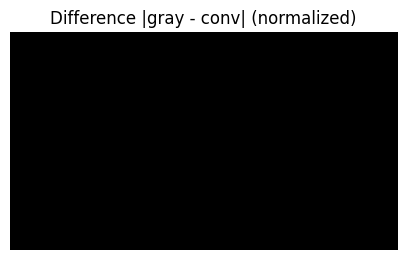

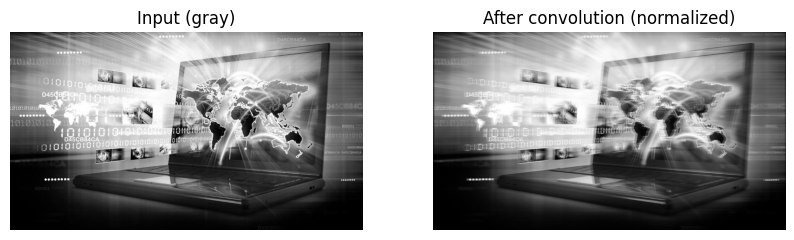

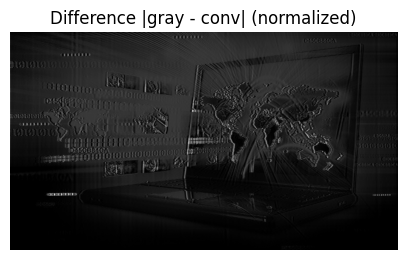

tensor([[0.0123, 0.0132, 0.0164,  ..., 0.0821, 0.0816, 0.0702],
        [0.0138, 0.0152, 0.0181,  ..., 0.0957, 0.0803, 0.0748],
        [0.0280, 0.0299, 0.0331,  ..., 0.1052, 0.0855, 0.0799],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [33]:
# Identity kernel — “do nothing”
identity = torch.tensor([[[[
    0, 0, 0,
    0, 1, 0,
    0, 0, 0
]]]])

random_conv = torch.tensor([[[[
    0.1, 0.5, 0.1,
    0.05, 0.05, 0.1,
    0.1, 0.2, 0.05
]]]])

plot_conv(gray, identity)
plot_conv(gray, random_conv)

### What it does

- Output ≈ input

- No change to image

- convolution doesn’t have to change the image
CNNs can learn when not to modify features.

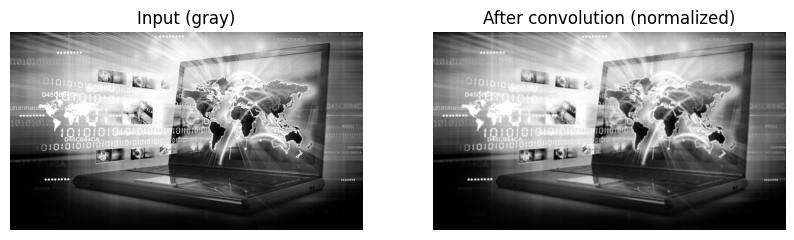

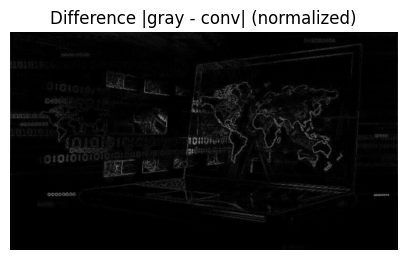

tensor([[0.0165, 0.0207, 0.0191,  ..., 0.0643, 0.0597, 0.0434],
        [0.0259, 0.0341, 0.0339,  ..., 0.0967, 0.0888, 0.0627],
        [0.0409, 0.0554, 0.0567,  ..., 0.1049, 0.0983, 0.0699],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [34]:
# Blur / Gaussian smoothing — reduce noise
gaussian_blur = torch.tensor([[[[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]]]])
plot_conv(gray, gaussian_blur)

### What it does

- Averages neighboring pixels
- Smooths textures
- Removes high-frequency noise

### What question it asks

“What is the average appearance in this area?”

### Why it’s important

- Makes models robust to noise
- Early CNN layers often learn blur-like filters
- Helps generalization



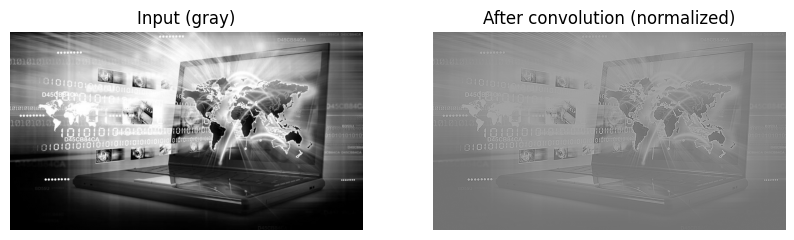

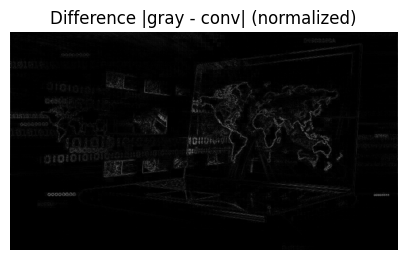

In [35]:
## Sharpen — enhance important details
sharpen = torch.tensor([[[[0,-1,0],[-1,5,-1],[0,-1,0]]]])
y= plot_conv(gray, sharpen)

### What it does

- Amplifies differences from neighbors
- Enhances edges and details

### What question it asks

“Is this pixel very different from its surroundings?”

### Why it’s important

- Highlights discriminative features
- CNNs learn to amplify what matters
- Improves separability of objects

### What is an “edge”?

An edge means:

- pixels on one side are darker

- pixels on the other side are brighter

- So an edge is a large gradient.

Gradient intuition

- Small change → smooth region

- Big change → edge

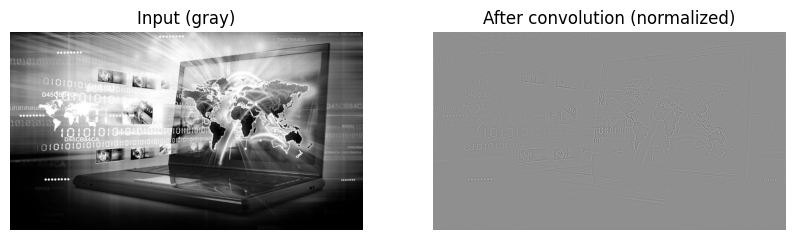

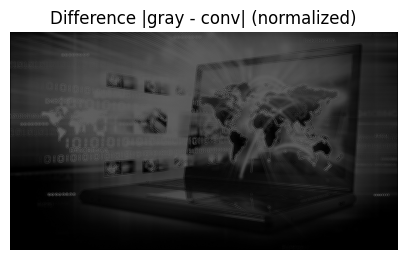

tensor([[ 0.0722,  0.0287,  0.0185,  ...,  0.0242,  0.0642,  0.1393],
        [-0.0045, -0.0275, -0.0287,  ...,  0.0717, -0.0299,  0.0811],
        [ 0.0516, -0.0099,  0.0058,  ...,  0.0756, -0.0228,  0.0976],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [36]:
# Laplacian — all edges
laplacian = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]])

plot_conv(gray, laplacian)

### What it does

- Responds to any sudden change

- Flat regions ≈ zero

### What question it asks

“Is this location structurally important?”

### Why it’s important

- Separates shape from texture

- CNNs rely heavily on structure

- Useful for object boundaries

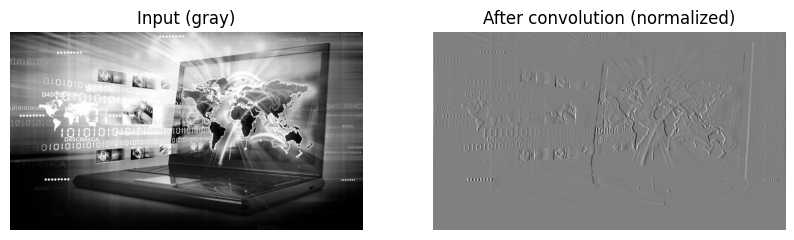

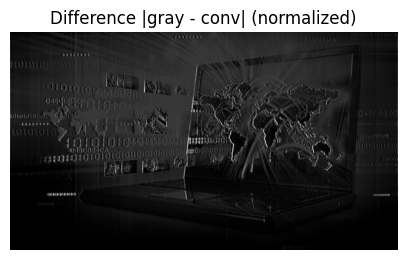

tensor([[ 0.0826, -0.0157, -0.0099,  ..., -0.0440, -0.0297, -0.2314],
        [ 0.1354, -0.0039,  0.0007,  ..., -0.0427, -0.0830, -0.3344],
        [ 0.2206,  0.0118,  0.0090,  ..., -0.0255, -0.0808, -0.3729],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [37]:
# Sobel X — vertical edges
sobel_x = torch.tensor([[[[-1,0,1],[-2,0,2],[-1,0,1]]]])   # vertical edges
plot_conv(gray, sobel_x)

###What it does

- Detects horizontal edges

- Complementary to Sobel X

### What question it asks

“Is there a horizontal boundary here?”

### Why it’s important

- Different orientations encode different semantics

- CNNs stack orientation-aware features

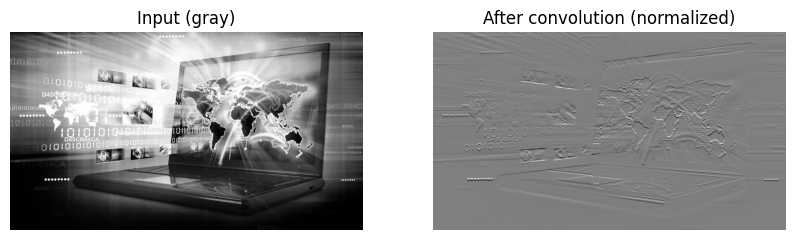

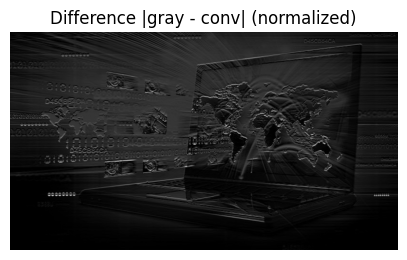

tensor([[0.0809, 0.1079, 0.1090,  ..., 0.3987, 0.3603, 0.2493],
        [0.0697, 0.1073, 0.1285,  ..., 0.1188, 0.1053, 0.0599],
        [0.1703, 0.2336, 0.2364,  ..., 0.0136, 0.0465, 0.0556],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [38]:
# Sobel Y — horizontal edges

sobel_y = torch.tensor([[[[-1,-2,-1],[0,0,0],[1,2,1]]]])   # horizontal edges
plot_conv(gray, sobel_y)

### What it does

- Responds strongly to vertical intensity changes
- Ignores horizontal changes

### What question it asks

“Is there a vertical boundary here?”

### Why it’s important

- Orientation matters in vision

- CNNs learn direction-specific filters

- Edges are fundamental building blocks

# Cooking up a CNN 🧑‍🍳

This part is was addapted from https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter5_cnns-pt1.html



### Input

PyTorch image tensor shape:
`[B, C, H, W]`

- B = batch size

- C = channels (RGB → 3)

- H, W = height, width


### 🥮 Ingredient 1: Convolutional Layers

- I showed some example kernels above. In CNNs the actual values in the kernels are the weights your network will learn during training: your network will learn what structures are important for prediction.

In PyTorch, convolutional layers are defined as `torch.nn.Conv2d`, there are 5 important arguments we need to know:

- `in_channels` = Number of channels in the input image (e.g., 3 for RGB images).

- `out_channels` = how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network.

-  `kernel_size` = Size of the convolving kernel (filter). Can be a single integer for a square kernel (e.g., 3 for 3x3), or a tuple (height, width).

- `stride` = the “step-size” of the kernel.

-  `padding` =  the number of pixels we should pad to the outside of the image so we can get edge pixels.
Padding is used to maintain the spatial dimensions of the output.


Note:

With CNN we are no longer flattening our data, so what are our “features”? Our features are called “channels” in CNN-lingo -> they are like the colour channels in an image:

A grayscale image has 1 feature/channel

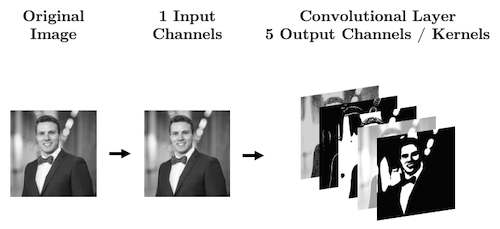


A coloured image has 3 features/channel

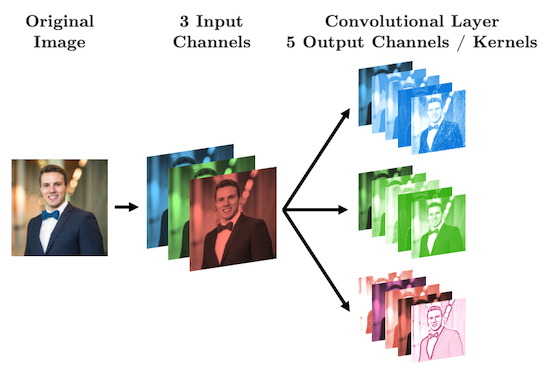



## 🥫 Ingredient 2: Activation functions

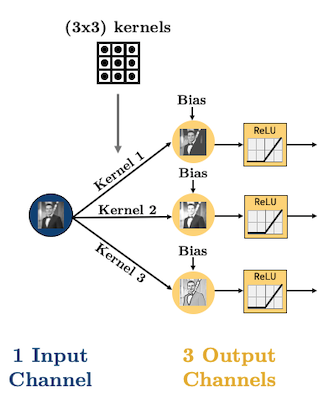

Examples:
1. `nn.ReLU()`
$$f(x)=max(0,x) $$

2. `nn.LeakyReLU(negative_slope=0.01) `

$$ Leaky ReLU(x)= {x \text{ if } x>0 , \text{ else }\  0.01x} $$

### 🍟 Ingredient 3: Flattening
With our brand new, shiny convolutional layers, we’re basically just passing images through the network - cool!

But we’re going to eventually want to do some regression or classification. That means that by the end of our network, we are going to need to torch.nn.Flatten() our images:

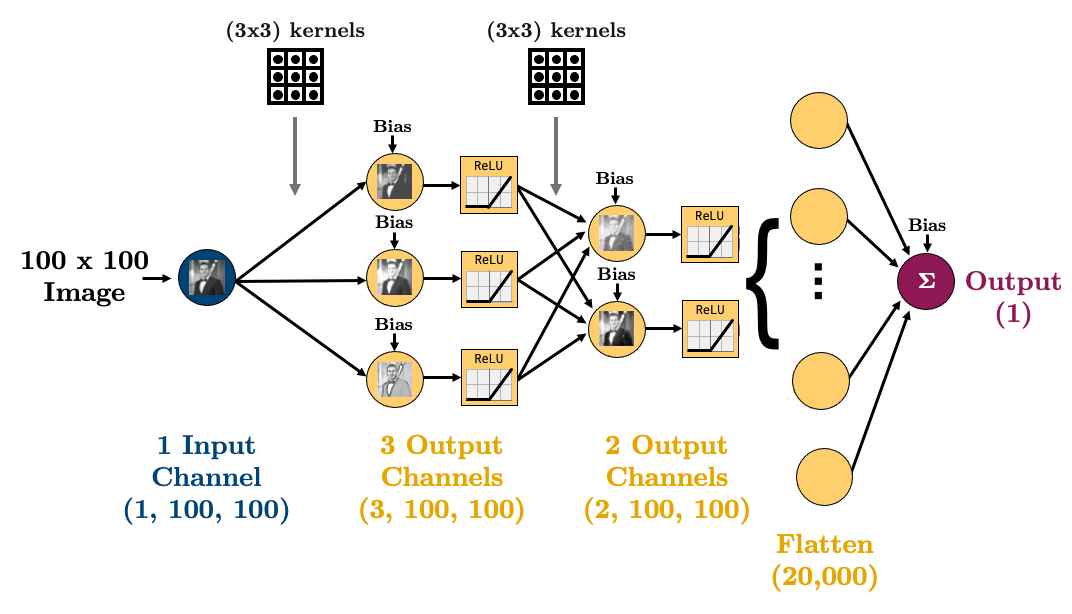

Let’s make that simple CNN above in PyTorch:

In [39]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1,bias=True),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1,bias=True),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(20000, 1)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [40]:
model = CNN()
summary(model, input_size=(1, 1, 100, 100)) #[B, C, H, W]

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 3, 100, 100]          30
│    └─ReLU: 2-2                         [1, 3, 100, 100]          --
│    └─Conv2d: 2-3                       [1, 2, 100, 100]          56
│    └─ReLU: 2-4                         [1, 2, 100, 100]          --
│    └─Flatten: 2-5                      [1, 20000]                --
│    └─Linear: 2-6                       [1, 1]                    20,001
Total params: 20,087
Trainable params: 20,087
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.04
Forward/backward pass size (MB): 0.40
Params size (MB): 0.08
Estimated Total Size (MB): 0.52

### Oh 😳! 20,000 parameters in that last layer, geez. Is there a way we can reduce this somehow? Glad you asked! See you in the next section.



## 🥨 Ingredient 4: Pooling

Pooling is how we can reduce the number of parameters we get out of a torch.nn.Flatten(). It’s pretty simple, we just aggregate the data, usually using the maximum or average of a window of pixels `torch.nn.MaxPool2d()`.

Here’s an example of max pooling:

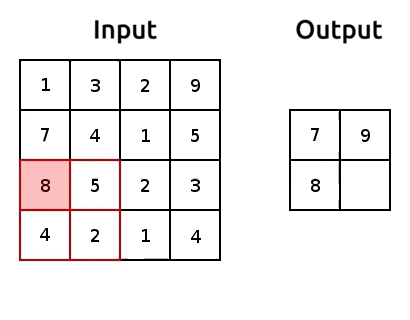


In [42]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1, bias=True),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Flatten(),
            torch.nn.Linear(1250, 1)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
model = CNN()
summary(model, input_size=(1, 1, 100, 100))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 3, 100, 100]          30
│    └─ReLU: 2-2                         [1, 3, 100, 100]          --
│    └─MaxPool2d: 2-3                    [1, 3, 50, 50]            --
│    └─Conv2d: 2-4                       [1, 2, 50, 50]            56
│    └─ReLU: 2-5                         [1, 2, 50, 50]            --
│    └─MaxPool2d: 2-6                    [1, 2, 25, 25]            --
│    └─Flatten: 2-7                      [1, 1250]                 --
│    └─Linear: 2-8                       [1, 1]                    1,251
Total params: 1,337
Trainable params: 1,337
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.44
Input size (MB): 0.04
Forward/backward pass size (MB): 0.28
Params size (MB): 0.01
Estimated Total Size (MB): 0.33

## Now its your turn!

Task 1 : Fill-the-blanks

In [56]:
class Net(nn.Module):
    """
    Task: Implement the CNN for MNIST.
    Goal: 1×28×28 -> logits for 10 classes
    """

    def __init__(self):
        super().__init__()

        # conv1: in_channels=1, out_channels=6, kernel_size=5
        #   Learns 6 different 5×5 filters on the 1-channel input (grayscale).
        #   each spatial dim shrinks by 4: 28→24.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)

        # TODO 2: Define maxpool: kernel_size=2, stride=2
        self.pool  = nn.MaxPool2d((2,2), 2)

        # TODO 3: Define conv2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # After conv/pool blocks: (B, 16, 4, 4) -> flatten -> 256
        # TODO 4: Define fc1 (Fully connected): 256 -> 120
        self.fc1   = nn.Linear(256, 120)

        # TODO 5: Define fc2: 120 -> 84
        self.fc2   = nn.Linear(120, 84)

        # TODO 6: Define fc3: 84 -> 10
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        # TODO 7: Implement forward pass (conv->relu->pool twice, then flatten, then fc layers)
        # Use F.relu(...)
        # Use torch.flatten(x, 1)

        # Block 1 - conv1 → ReLU → pool
        x = self.conv1(x)          # (B, 6, 24, 24)   28→24 (k=5, s=1, p=0)
        x = F.relu(x)              # (B, 6, 24, 24)   nonlinearity
        x = self.pool(x)           # (B, 6, 12, 12)   24→12

        # Block 2 - conv2 → ReLU → pool
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, 1)
        # Classifier
        x = F.relu(self.fc1(x))    # (B, 120)
        x = F.relu(self.fc2(x))    # (B, 84)
        x = self.fc3(x)            # (B, 10)          logits (use CrossEntropyLoss)


        return x

net = Net().to(device)

Loss

For a full list of available loss functions in PyTorch, visit: https://docs.pytorch.org/docs/stable/nn.html#id1.


In [57]:
criterion = nn.CrossEntropyLoss()

Optimizer

https://docs.pytorch.org/docs/stable/optim.html

In [58]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Summary

In [59]:
summary(model=net, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 6, 24, 24]           156
├─MaxPool2d: 1-2                         [64, 6, 12, 12]           --
├─Conv2d: 1-3                            [64, 16, 8, 8]            2,416
├─MaxPool2d: 1-4                         [64, 16, 4, 4]            --
├─Linear: 1-5                            [64, 120]                 30,840
├─Linear: 1-6                            [64, 84]                  10,164
├─Linear: 1-7                            [64, 10]                  850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 18.33
Input size (MB): 0.20
Forward/backward pass size (MB): 2.40
Params size (MB): 0.18
Estimated Total Size (MB): 2.78

## Traning

In [61]:
# --- history containers ---
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

EPOCHS = 10 #TODO
for epoch in range(1, EPOCHS+1):
    # ---- train / eval ? ----
    net.train() #TODO .eval() /  .train()
    total_loss, total_correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = net(xb)
        loss = criterion(logits, yb)
        loss.backward()  #TODO .zero_grad() / .backward() / .step() / criterion(logits, yb)
        optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)

    train_loss = total_loss / total
    train_acc  = total_correct / total

    # ---- train / eval ? ----
    net.eval() #TODO .eval() /  .train()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = net(xb) # TODO net(xb) / net(yb) / .zero_grad() / .step()
            loss = criterion(logits, yb) #TODO
            # TODO add optimizer.step() if needed
            val_loss += float(loss.item()) * xb.size(0)
            val_correct += (logits.argmax(1) == yb).sum().item()
            val_total += xb.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # --- store history ---
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.3f} "
          f"| val_loss={val_loss:.4f} acc={val_acc:.3f}")

Epoch 01 | train_loss=1.7321 acc=0.441 | val_loss=0.4545 acc=0.861
Epoch 02 | train_loss=0.2930 acc=0.909 | val_loss=0.2051 acc=0.938
Epoch 03 | train_loss=0.1634 acc=0.950 | val_loss=0.1419 acc=0.957
Epoch 04 | train_loss=0.1209 acc=0.962 | val_loss=0.1195 acc=0.964
Epoch 05 | train_loss=0.0983 acc=0.970 | val_loss=0.1139 acc=0.966
Epoch 06 | train_loss=0.0839 acc=0.974 | val_loss=0.0942 acc=0.972
Epoch 07 | train_loss=0.0746 acc=0.977 | val_loss=0.0880 acc=0.973
Epoch 08 | train_loss=0.0687 acc=0.979 | val_loss=0.0753 acc=0.978
Epoch 09 | train_loss=0.0620 acc=0.981 | val_loss=0.0711 acc=0.979
Epoch 10 | train_loss=0.0580 acc=0.982 | val_loss=0.0709 acc=0.980


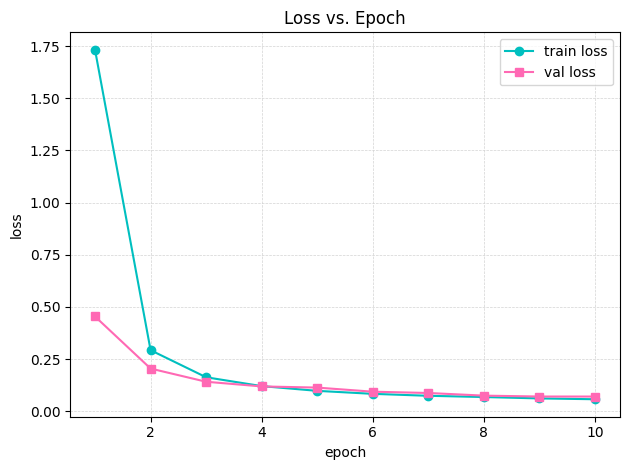

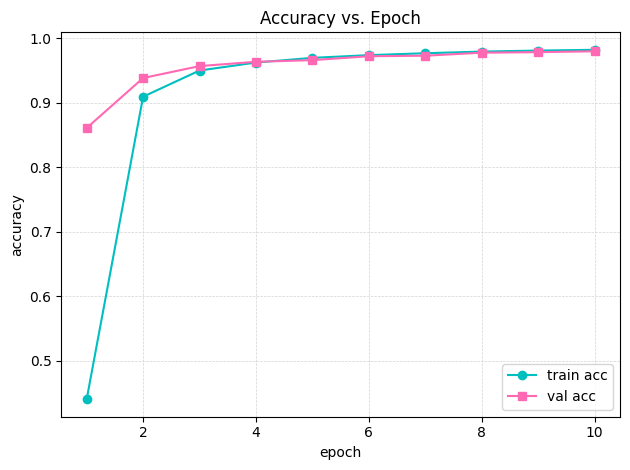

In [62]:
epochs = range(1, EPOCHS+1)

# --- Plot 1 ---
plt.figure()
plt.plot(epochs, train_losses, marker='o', label='train loss',color='c')
plt.plot(epochs, val_losses,   marker='s', label='val loss', color='hotpink')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.tight_layout(); plt.show()

# --- Plot 2 ---
plt.figure()
plt.plot(epochs, train_accs, marker='o', label='train acc',color='c')
plt.plot(epochs, val_accs,   marker='s', label='val acc',color='hotpink')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(color = 'lightgray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.show()

## Explanability

Interpreting the Grad-CAM

What is this?
Grad-CAM highlights where the network “looked” in the image to make its prediction. Warmer colors (red/yellow) indicate regions that most influenced the chosen class, cooler colors (blue) contribute less.


Note:

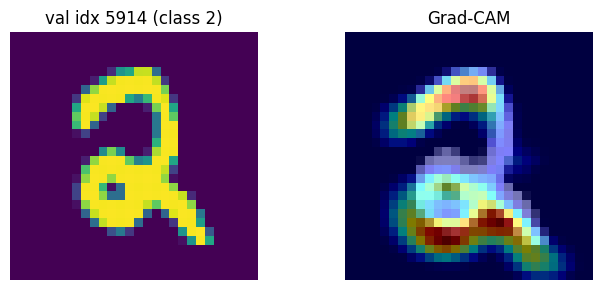

In [67]:
net.eval()

# Choose a random validation example
ds = val_dataset

# Set Random index
g = torch.Generator().manual_seed(int(time.time_ns()) % (2**31 - 1))
idx = torch.randint(0, len(ds), (1,), generator=g).item()

# Fetch sample
x, y = ds[idx]                       # x: (C,H,W), y: int

# Prepare input for the model
# Adds a batch dimension (so it’s shaped like a real batch).
input_tensor = x.unsqueeze(0).to(device)  # (1,C,H,W)
target_class = int(y)

# Pick which conv layer Grad-CAM should explain
target_layer = net.conv1

# Run Grad-CAM
with GradCAM(model=net, target_layers=[target_layer]) as cam:
    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(target_class)])[0]  # (H,W)

# Undo dataset normalization for visualization
C, H, W = x.shape
MEAN, STD = (0.1307,), (0.3081,)


def denorm(img_t, mean, std):
    mean_t = torch.tensor(mean)[:, None, None]
    std_t  = torch.tensor(std)[:, None, None]
    return (img_t * std_t + mean_t).clamp(0, 1)

img = denorm(input_tensor[0].detach().cpu(), MEAN, STD).numpy()  # (C,H,W)

# Convert grayscale image to RGB (Grad-CAM overlay expects RGB)
rgb = img.transpose(1,2,0)                                       # (H,W,C)
rgb = np.repeat(rgb, 3, axis=2)  # replicate grayscale to RGB

# Overlay the heatmap on the image
cam_image = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)


#Left: the raw validation image
# Right: the Grad-CAM overlay
plt.figure(figsize=(7,3))
plt.subplot(1,2,1);
plt.imshow(img[0] if C==1 else rgb);
plt.title(f"val idx {idx} (class {target_class})");
plt.axis('off')

plt.subplot(1,2,2);
plt.imshow(cam_image);
plt.title("Grad-CAM");
plt.axis('off')

plt.tight_layout(); plt.show()

## Evaluation

In [68]:
def evaluate(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb, reduction='sum')  # sum over batch
            total_loss += loss.item()
            total_correct += (logits.argmax(1) == yb).sum().item()
            total += xb.size(0)
    return total_loss / total, total_correct / total

In [69]:
test_loss, test_acc = evaluate(net, val_loader, device)
print(f"TEST: loss={test_loss:.4f} | acc={test_acc:.4f}")

TEST: loss=0.0709 | acc=0.9798


In [70]:
def per_class_accuracy(model, loader, device, num_classes=10):
    " Compute accuracy per class on a (single-label) classification dataset."
    model.eval()
    correct = np.zeros(num_classes, dtype=np.int64)
    counts  = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            for t, p in zip(yb.view(-1), pred.view(-1)):
                counts[int(t)]  += 1
                correct[int(t)] += int(t == p)

    return correct / np.maximum(counts, 1)

In [71]:
accs = per_class_accuracy(net, val_loader, device, num_classes=10)

for i, a in enumerate(accs):
    print(f"class {i}: acc={a:.3f}")

class 0: acc=0.976
class 1: acc=0.990
class 2: acc=0.976
class 3: acc=0.959
class 4: acc=0.982
class 5: acc=0.989
class 6: acc=0.986
class 7: acc=0.984
class 8: acc=0.981
class 9: acc=0.975


In [72]:
def confusion_matrix(model, loader, device, num_classes=10):
    model.eval()
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1
    return cm

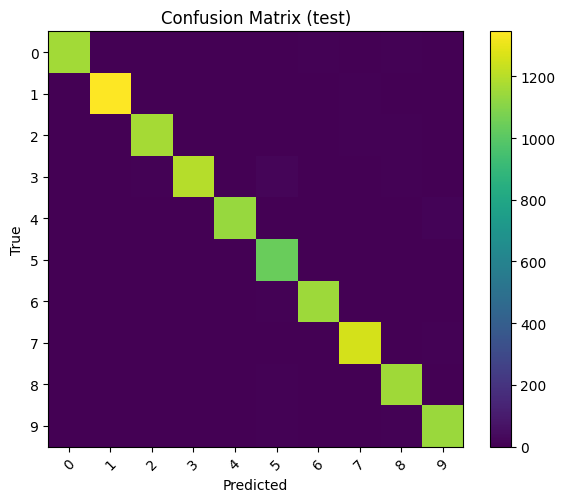

In [73]:
cm = confusion_matrix(net, val_loader, device, num_classes=10).cpu().numpy()

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(range(10), [str(i) for i in range(10)], rotation=45)
plt.yticks(range(10), [str(i) for i in range(10)])
plt.colorbar()
plt.tight_layout()
plt.show()

## Why isn't it 100% ❓


In [74]:
def get_preds(model, loader, device):
    " Run the model over a DataLoader and collect predictions, probabilities, and targets."
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_targets.append(yb.clone())
    logits = torch.cat(all_logits)            # (N, num_classes)
    targets = torch.cat(all_targets)          # (N,)
    probs = torch.softmax(logits, dim=1)      # turn logits into probabilities
    preds = probs.argmax(1)
    return preds, probs, targets

preds, probs, targets = get_preds(net, val_loader, device)

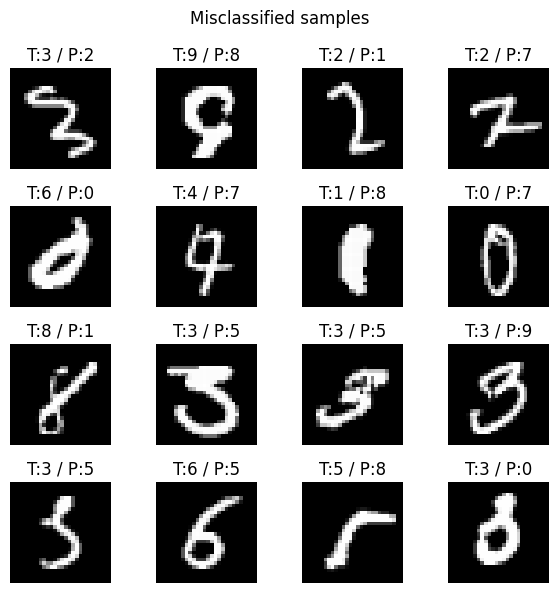

In [75]:
mis_idx = (preds != targets).nonzero(as_tuple=False).squeeze(1)[:16]

# grab the raw (denormalized) images from the loader again for display
MEAN, STD = 0.1307, 0.3081

imgs, true_lbls, pred_lbls = [], [], []
seen = 0
for xb, yb in val_loader:
    b = xb.size(0)
    p = net(xb.to(device)).argmax(1).cpu()
    for i in range(b):
        if seen in mis_idx:
            img = xb[i,0].numpy() * STD + MEAN
            imgs.append(img)
            true_lbls.append(int(yb[i]))
            pred_lbls.append(int(p[i]))
            if len(imgs) >= 16: break
        seen += 1
    if len(imgs) >= 16: break

plt.figure(figsize=(6,6))
for i, img in enumerate(imgs):
    plt.subplot(4,4,i+1)
    plt.imshow(np.clip(img, 0, 1), cmap='gray')
    plt.title(f"T:{true_lbls[i]} / P:{pred_lbls[i]}")
    plt.axis('off')
plt.suptitle("Misclassified samples"); plt.tight_layout(); plt.show()

### Are you satisfied with your model? If so, make sure to save it!


Save weights

In [76]:
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = f"{ckpt_dir}/best_cnn.pt"

# SAVE: store model weights (and optimizer if you’ll resume training)
torch.save({
    "model_state": net.state_dict(),
    # include the next line only if you plan to continue training later
    "optim_state": optimizer.state_dict(),
}, ckpt_path)
print("Saved to:", ckpt_path)

Saved to: checkpoints/best_cnn.pt


Load weights

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net2 = Net().to(device)  # recreate the same architecture
ckpt = torch.load("checkpoints/best_cnn.pt", map_location=device)

net2.load_state_dict(ckpt["model_state"])
net2.eval()  # set eval mode for inference

# (optional) resume training
# optimizer.load_state_dict(ckpt["optim_state"])

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)